# Assignment for practical work 4. Basics of neural networks

Group:

*  Jannik Bucher
*  Dennis Imhof

### Using dataset: SkillCraft1 Master Table Dataset
[SkillCraft1 on UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset#)

#### Notes:

* Other than in assignment 2a we will now use the original response variable "LeagueIndex" for classification.

* Also, we will split the data into train and test set and perform cross-validation on the training data instead of splitting the training data into fixed train/validation sets.

# Assignment for practical work 4. Basics of neural networks
## General Assignment

Before performing the practical work, you need download the data set accordingly to the option on your machine
1. Write a program that splits the original sample into a training set and a test set (training set, validation set, test set)
2. Build a model using Perceptron (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) and MLPClassifier (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html). On the basis of experiments, select values for learning rate, the regularization parameter, the optimization function.
3. Build learning curves for better explanation of your experiments.

## Options
Data sets are taken from the UCI Machine Learning Repository
https://archive.ics.uci.edu/ml/
The option is determined by the data set, which can be downloaded from the link above:
The option is determined by the data set, which can be downloaded from the link above:
1. Sponge
2. Water Treatment Plant
3. Synthetic Control Chart Time Series
4. Character Trajectories
5. Plants
6. Libras Movement
7. KEGG Metabolic Relation Network (Directed)
8. SMS Spam Collection
9. seeds
10. Human Activity Recognition Using Smartphones
11. User Knowledge Modeling
12. NYSK
13. Activities of Daily Living (ADLs) Recognition Using Binary Sensors
14. Dresses_Attribute_Sales
15. Wholesale customers
16. StoneFlakes
17. Gesture Phase Segmentation
18. AAAI 2014 Accepted Papers
19. Dow Jones Index
20. AAAI 2013 Accepted Papers
21. wiki4HE
22. Folio
23. Mice Protein Expression
24. Improved Spiral Test Using Digitized Graphics Tablet for Monitoring Parkinson’s Disease


In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
columns = ["{}{}".format(l,i) 
           for l in [chr(x) for x in range(97,104)] 
           for i in range(1,7)]
df = pd.read_csv('data/connect-4.data', header=None)#, names=columns)

In [3]:
df.columns=columns+["result"]

In [4]:
X, y = df.drop('result', axis=1), df['result']

In [5]:
df['a1'].unique()

array(['b', 'o', 'x'], dtype=object)

In [7]:
categories = ['b', 'o', 'x']
oe = OrdinalEncoder()
X = pd.DataFrame(data=oe.fit_transform(X),
                  columns=columns)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

In [9]:
cross_val_score(Perceptron(random_state=42), X_train, y_train, cv=10)

array([0.38393235, 0.63234672, 0.64389934, 0.65891309, 0.57728907,
       0.49566505, 0.48678368, 0.61915838, 0.64107445, 0.62724773])

In [10]:

cross_val_score(RandomForestClassifier(n_estimators=20, 
                                       criterion="gini", random_state=42), 
                X_train, y_train, cv=10)

array([0.79978858, 0.79450317, 0.79894292, 0.79974625, 0.80080355,
       0.78219497, 0.79424826, 0.7965313 , 0.79949239, 0.80241168])

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [84]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=3, scoring=scoring, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    best_test_score = param_range[np.argmax(test_scores_mean)]
    best_train_score = param_range[np.argmax(train_scores_mean)]

    plt.figure(figsize=(9,9))
    plt.title("Validation Curve\nBest test param: {}".format(best_test_score))
    plt.xlabel("{}".format(param_name))
    plt.ylabel("{}".format(scoring))
    #plt.ylim(0.1, 0.4)
    lw = 2
    plt.semilogx(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.axvline(best_test_score, color='darkorange')
    plt.axvline(best_train_score, color='navy')
    plt.legend(loc="best")
    plt.show()

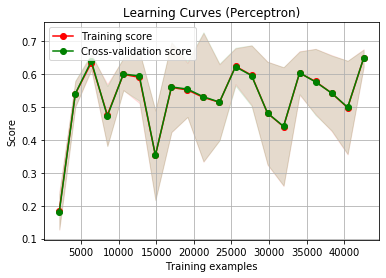

In [13]:
title = "Learning Curves (Perceptron)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = Perceptron(penalty='l2', alpha=0.1, max_iter=1000)
plot_learning_curve(estimator, title, X_train, y_train, cv=10, n_jobs=-1, 
                    train_sizes=np.linspace(0.05,1,20))

plt.show()

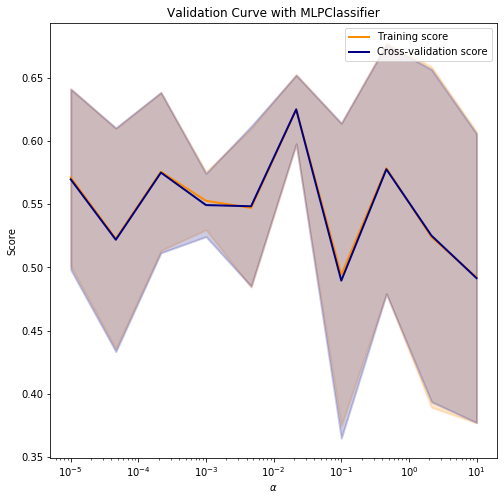

In [16]:
param_range = np.logspace(-5, 1, 10)
train_scores, test_scores = validation_curve(
    Perceptron(penalty='l1'), X_train, y_train, param_name="eta0", param_range=param_range,
    cv=3, scoring="accuracy", n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,8))
plt.title("Validation Curve with MLPClassifier")
plt.xlabel(r"$\alpha$")
plt.ylabel("Score")
#plt.ylim(0.1, 0.4)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

## Learning Curves

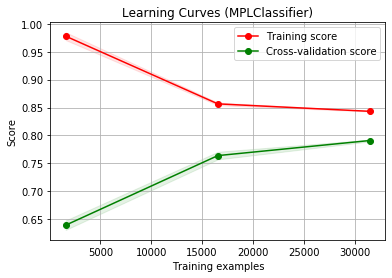

In [14]:
title = "Learning Curves (MPLClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
estimator = MLPClassifier(hidden_layer_sizes=(43,43,43,43), alpha=0.1, max_iter=100, )
plot_learning_curve(estimator, title, X_train, y_train, cv=3, n_jobs=-1, 
                    train_sizes=np.linspace(0.05,1,3))

plt.show()

In [15]:
elements = []
with open('data/page-blocks.data') as f:
    for l in f:       
        elements.append([float(x) for x in l.split()])
        
elements = np.array(elements)

In [21]:
columns = ['height', 
           'lenght', 
           'area',
           'eccen',
           'p_black',
           'p_and',
           'mean_tr',
           'blackpix',
           'blackand',
           'wb_trans',
           'block']

In [23]:
df = pd.DataFrame(elements, columns=columns)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("block", axis=1), df["block"], train_size=0.7)

In [26]:
X_train.describe()

,height,lenght,area,eccen,p_black,p_and,mean_tr,blackpix,blackand,wb_trans
count,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000,3831.000000
mean,10.430697,90.163143,1187.638476,14.209943,0.370391,0.785206,6.725756,375.559645,746.392848,106.112764
std,16.158463,115.170060,4366.653481,31.945762,0.180998,0.170986,81.897773,1332.484024,1902.356187,161.506966
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000
25%,7.000000,17.500000,114.500000,2.167000,0.261000,0.677500,1.600000,43.000000,96.000000,17.000000
50%,8.000000,41.000000,324.000000,5.222000,0.336000,0.804000,2.070000,109.000000,249.000000,49.000000
75%,10.000000,107.500000,972.000000,13.714000,0.426000,0.927000,3.050000,283.500000,704.500000,124.500000
max,430.000000,553.000000,142290.000000,537.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,2925.000000


In [31]:
scale = StandardScaler()
X_train_scaled = pd.DataFrame(scale.fit_transform(X_train), columns=X_train.columns)

In [33]:
cross_val_score(Perceptron(), X_train_scaled, y_train, cv=5, n_jobs=-1, scoring="accuracy")

array([0.95318596, 0.95169713, 0.94778068, 0.95169713, 0.95418848])

In [37]:
cross_val_score(MLPClassifier(hidden_layer_sizes=(100,100)), X_train, y_train, cv=5, n_jobs=-1, scoring="accuracy")

array([0.95578674, 0.95430809, 0.95169713, 0.96475196, 0.96335079])

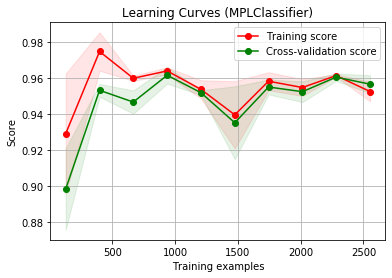

In [48]:
title = "Learning Curves (MPLClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
mlp = MLPClassifier(hidden_layer_sizes=(100,100), alpha=0.1, max_iter=100, random_state=42)
plot_learning_curve(mlp, title, X_train, y_train, cv=3, n_jobs=-1, 
                    train_sizes=np.linspace(0.05,1,10))

plt.show()

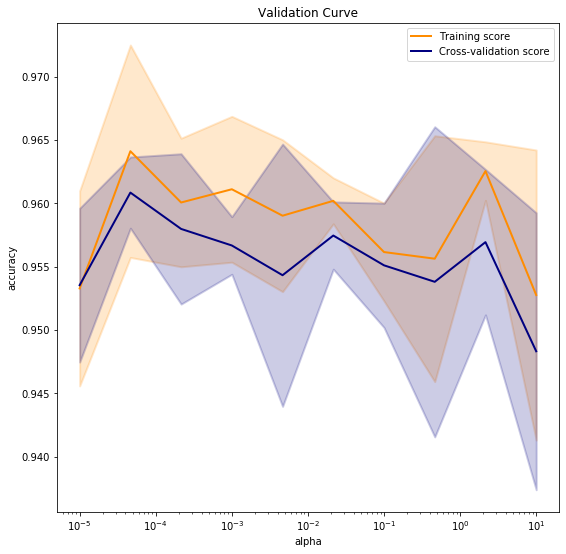

In [49]:
param_range = np.logspace(-5,1, 10)
plot_validation_curve(mlp, "", X_train, y_train, "alpha", param_range)

In [60]:
param_range

array([100, 200, 300, 400, 500, 600, 700, 800, 900])

In [79]:
params_mlp = {'hidden_layer_sizes' : [(200, 200, 300), (200, 200, 300, 300)]}

In [76]:
grid_mlp = GridSearchCV(mlp, params_mlp, scoring="accuracy", n_jobs=-1, cv=3)
grid_mlp.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.1,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08,
                                     hidden_layer_sizes=(100, 100),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=100,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=42, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'hidden

In [83]:
grid_mlp.best_params_, grid_mlp.best_score_

({'hidden_layer_sizes': (200, 200, 300)}, 0.968154528843644)

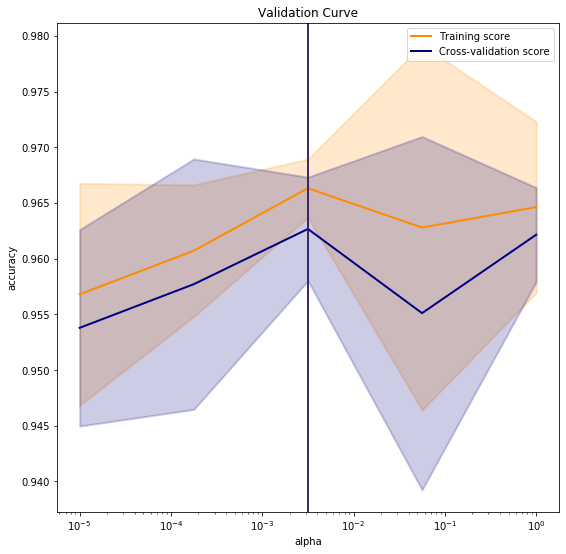

In [82]:
param_range = np.logspace(-5, 0, 5)
plot_validation_curve(MLPClassifier(hidden_layer_sizes=(200, 200, 300), random_state=42), "", X_train, y_train, "alpha", param_range)

In [88]:
print("Test accuracy with best parameter model: {}".format(accuracy_score(y_test, grid_mlp.predict(X_test))))

Test accuracy with best parameter model: 0.9622411693057247


In [95]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
cross_val_score(rf, X_train, y_train, scoring="accuracy", cv=10, verbose=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished


array([0.97922078, 0.98177083, 0.97916667, 0.97135417, 0.95833333,
       0.9765625 , 0.96335079, 0.97382199, 0.97905759, 0.98947368])

In [96]:
rf.predict(X_test)

NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [42]:
import keras

Using TensorFlow backend.
/home/den/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/den/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/den/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/den/a